# Resonator and Qubit Spectroscopy with HDAWG and UHFQA

This notebook demonstrates pulsed resonator and pulsed qubit spectroscopy experiments with the HDAWG and UHFQA.
In contrast to the SHF instruments, which can sweep their oscillator frequencies in real time (see [this notebook](https://github.com/zhinst/laboneq/blob/main/examples/basic_experiments.ipynb)), HDAWG and UHFQA require sweeps in near time.

## 0. LabOne Q Imports

You'll begin by importing `laboneq.simple` and some extra helper functions to run the examples. 

In [1]:
# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_results,
    plot_simulation,
)
from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from pathlib import Path

In [2]:
# Build an in-memory data store with device setup and qubit parameters for the
# example notebooks
setup_db = generate_example_datastore(in_memory=True)

## 1. Device Setup

Below, you'll create a device setup and specify to run in an emulated mode or on hardware, `emulate = True/False` respectively.

If you run on your hardware, the [descriptor](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment/) called by `create_device_setup` should be replaced by one of your own, generally stored as a [YAML file](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment/#labone_q.func_concepts.setting_up.set_up_equipment.descriptor). Once you have this descriptor, it can be reused for all your experiments.

In [3]:
# load a calibrated device setup from the dummy database
device_setup = get_first_named_entry(
    db=setup_db, name="2_qubit_setup_hdawg_uhfqa_pqsc_calibrated"
)
use_emulation = True

\\home\home\sam68451\LabOneQ Software Local Samuel\laboneq\laboneq\dsl\calibration\oscillator.py:58: FutureWarning: `Oscillator` argument `carrier_type` will be removed in the future versions. It has no functionality.
  warnings.warn(


## 2. Pulsed Resonator Spectroscopy

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line.

### 2.1 Experiment Definition

In [4]:
# define sweep parameter - sweep over frequency of readout pulse
start = -300e6
stop = 300e6
count = 21

frequency_sweep_parameter = LinearSweepParameter(
    uid="frequency_sweep", start=start, stop=stop, count=count
)

# define number of averages
average_exponent = 4  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment - uses only a readout pulse and a data acquisition line
exp_spec = Experiment(
    uid="Resonator Spectroscopy",
    signals=[
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)

## experimental pulse sequence
# Define an acquisition loop of type SPECTROSCOPY
with exp_spec.sweep(uid="sweep", parameter=frequency_sweep_parameter):
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=pow(2, average_exponent),
        averaging_mode=AveragingMode.SEQUENTIAL,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        # readout pulse and data acquisition
        with exp_spec.section(uid="spectroscopy"):
            exp_spec.play(
                signal="measure", pulse=pulse_library.const(length=1e-6, amplitude=1.0)
            )
            exp_spec.acquire(
                signal="acquire",
                handle="ac_0",
                length=1e-6,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp_spec.section(uid="relax"):
            exp_spec.delay(signal="measure", time=1e-6)

In [5]:
# calibration for qubit 0
calib_q0 = Calibration()
calib_q0["measure"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=frequency_sweep_parameter,
        modulation_type=ModulationType.HARDWARE,
    )
)

In [6]:
# signal map for qubit 0
map_q0 = {
    "measure": "/logical_signal_groups/q0/measure_line",
    "acquire": "/logical_signal_groups/q0/acquire_line",
}

### 2.2 Run the Experiment and Plot the Measurement Results and Pulse Sequence

[2023.10.09 11:05:27.129] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\laboneq_output\log
[2023.10.09 11:05:27.136] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:05:27.139] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:05:27.143] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:05:27.161] INFO    Configuring the device setup
[2023.10.09 11:05:27.198] INFO    The device setup is configured
[2023.10.09 11:05:27.211] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:05:27.213] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:05:27.216] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:05:27.237] INFO    Configuring the device setup
[2023.10.09 11:05:27.278] INFO    The device setup is configured
[2023.10.09 

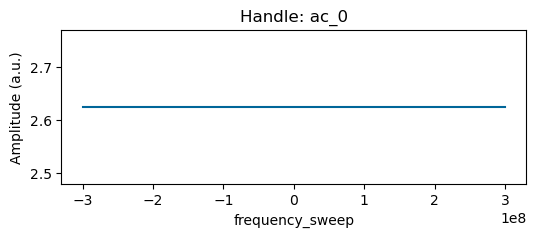

In [7]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# set experiment calibration and signal map
exp_spec.set_calibration(calib_q0)
exp_spec.set_signal_map(map_q0)

# run experiment
spec_results = session.run(exp_spec)

# plot measurement results
plot_results(spec_results)

In [8]:
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Pulse_Sheets/Resonator Spectroscopy", session.compiled_experiment)

[2023.10.09 11:05:33.114] INFO    Requesting more events for the PSV than currently published, recompiling experiment
[2023.10.09 11:05:33.121] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:05:33.124] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:05:33.129] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:05:33.139] INFO    Configuring the device setup
[2023.10.09 11:05:33.186] INFO    The device setup is configured
[2023.10.09 11:05:33.192] INFO    Starting LabOne Q Compiler run...
[2023.10.09 11:05:33.198] INFO    Schedule completed
[2023.10.09 11:05:33.213] INFO    Finished LabOne Q Compiler run.
[2023.10.09 11:05:33.275] INFO    Writing html file to u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\Pulse_Sheets\Resonator Spectroscopy_2023-10-09-11-05-33.html


u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\Pulse_Sheets\Resonator Spectroscopy_2023-10-09-11-05-33.html

## 3. Pulsed Qubit Spectroscopy

Find the resonance frequency of the qubit by looking at the change in resonator transmission when sweeping the frequency of a qubit excitation pulse.

### 3.1 Pulse Definitions

In [9]:
## define pulses

# qubit drive pulse
const_iq_100ns = pulse_library.const(uid="const_iq_100ns", length=100e-9, amplitude=1.0)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout weights for integration
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=200e-9, amplitude=1.0
)

### 3.2 Experiment Definition

In [10]:
# define sweep parameter - sweep over the frequency of a qubit excitation pulse
start = 40e6
stop = 200e6
count = 21

drive_frequency_sweep = LinearSweepParameter(
    uid="qubit_freq", start=start, stop=stop, count=count
)

# define number of averages
average_exponent = 4  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment - no explicit mapping to qubit lines
exp_qspec = Experiment(
    uid="Qubit Spectroscopy",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
with exp_qspec.sweep(uid="sweep", parameter=drive_frequency_sweep):
    with exp_qspec.acquire_loop_rt(
        uid="shots",
        count=pow(2, average_exponent),
        averaging_mode=AveragingMode.SEQUENTIAL,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # qubit excitation pulse - frequency will be swept
        with exp_qspec.section(
            uid="qubit_excitation", alignment=SectionAlignment.RIGHT
        ):
            exp_qspec.play(signal="drive", pulse=const_iq_100ns)
        # readout and data acquisition
        with exp_qspec.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp_qspec.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp_qspec.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp_qspec.section(uid="relax"):
            exp_qspec.delay(signal="measure", time=1e-6)

In [11]:
# define experiment calibration - sweep over qubit drive frequency
exp_calib = Calibration()
exp_calib["drive"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=drive_frequency_sweep,
        modulation_type=ModulationType.HARDWARE,
    )
)

# define signal maps for qubit 0
map_q0 = {
    "drive": device_setup.logical_signal_groups["q0"].logical_signals["drive_line"],
    "measure": device_setup.logical_signal_groups["q0"].logical_signals["measure_line"],
    "acquire": device_setup.logical_signal_groups["q0"].logical_signals["acquire_line"],
}

### 3.3 Run the Experiment and Plot the Measurement Results and Pulse Sequence

[2023.10.09 11:05:43.982] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\laboneq_output\log
[2023.10.09 11:05:43.988] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:05:43.990] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:05:43.994] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:05:44.005] INFO    Configuring the device setup
[2023.10.09 11:05:44.044] INFO    The device setup is configured
[2023.10.09 11:05:44.053] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:05:44.055] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:05:44.062] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:05:44.078] INFO    Configuring the device setup
[2023.10.09 11:05:44.123] INFO    The device setup is configured
[2023.10.09 

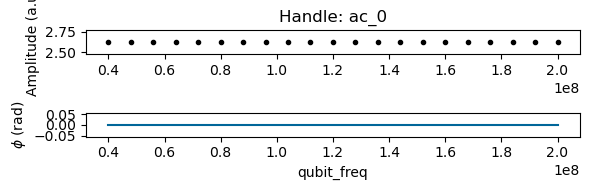

In [12]:
# set calibration and signal map for qubit 0
exp_qspec.set_calibration(exp_calib)
exp_qspec.set_signal_map(map_q0)

# create a session and connect to it
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 0
qspec_results = session.run(exp_qspec)

# plot measurement results
plot_results(qspec_results, phase=True)

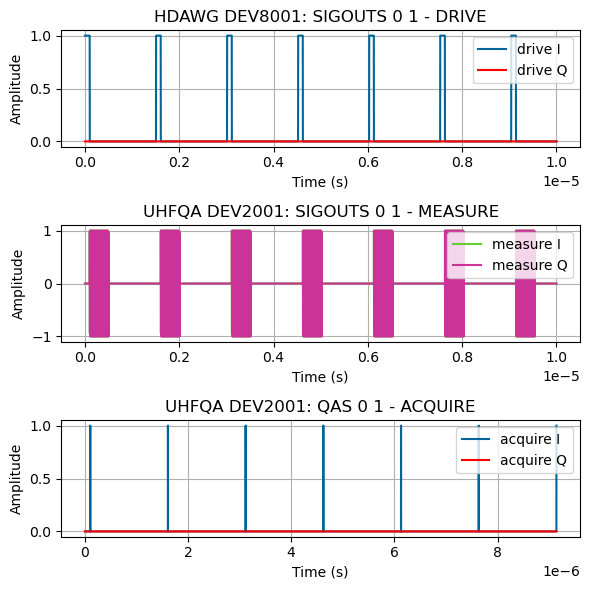

In [13]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)